Загрузим все необходимые библиотеки.

In [ ]:
import pandas as pd
import numpy as np

import torch
from torch import nn

from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

Далее работаем на GPU.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Загрузим наши данные из гитхаба.

In [ ]:
train_url = 'https://raw.githubusercontent.com/dxdydakov/My-Neural-Networks/main/MNIST/train.csv'
test_url = 'https://raw.githubusercontent.com/dxdydakov/My-Neural-Networks/main/MNIST/test.csv'

In [ ]:
train_data = pd.read_csv(train_url, dtype = np.float32)
test_data = pd.read_csv(test_url, dtype = np.float32)

Посмотрим как они выглядят в сыром виде.

In [ ]:
train_data.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_data.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

num_train_pixels = train_data.shape[1] -1
num_test_pixels = test_data.shape[1]

num_classes =  train_data['label'].unique().shape[0]

print(f'Here {num_train_samples} train samples and {num_test_samples} test samples.\n')
print(f'Number of training pixels: {num_train_pixels} pixels.')
print(f'Number of testing pixels: {num_test_pixels} pixels.')
print(f'Number of classes: {num_classes}.')

Here 42000 train samples and 28000 test samples.

Number of training pixels: 784 pixels.
Number of testing pixels: 784 pixels.
Number of classes: 10.


Посмотрим на структуру нашего тренировочного датасета

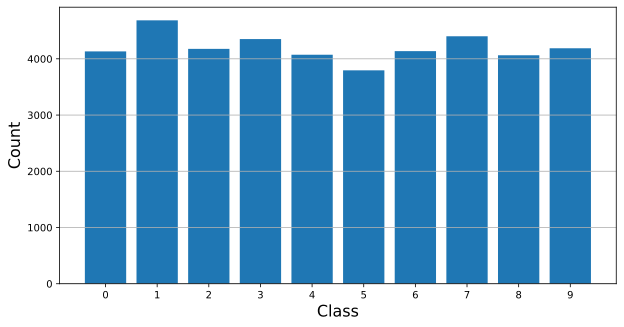

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(train_data['label'].value_counts().index, train_data['label'].value_counts())
plt.xticks(np.arange(num_classes))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')
plt.show()

Теперь хочу отдалиться от пандаса и работать с пацанскими тензорами.

In [ ]:
targets = train_data.label.values
features = train_data.loc[:, train_data.columns != 'label'].values/255

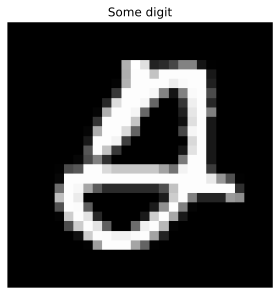

In [ ]:
def show_image(data, index):
  plt.imshow(data[index].reshape(28,28), cmap='gray')
  plt.axis("off")
  plt.title('Some digit')
  plt.show()

show_image(features, np.random.randint(0,len(features)))

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, targets, test_size=0.2, random_state=42)

In [ ]:
features_train.shape

(33600, 784)

In [ ]:
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(target_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(target_test).type(torch.LongTensor)

In [ ]:
featuresTrain.shape

torch.Size([33600, 784])

In [ ]:
batch_size = 128
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [ ]:
class cnn_mnist(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 10)
        
    self.dropout = nn.Dropout(p=0.2)
    self.log_softmax = F.log_softmax
    self.relu = nn.ReLU(inplace=True)
        
  def forward(self, x):
    x = self.dropout(self.relu(self.fc1(x)))
    x = self.dropout(self.relu(self.fc2(x)))
    x = self.dropout(self.relu(self.fc3(x)))
    x = self.dropout(self.relu(self.fc4(x)))
        
    x = self.log_softmax(self.fc5(x), dim=1)
        
    return x

In [ ]:
model = cnn_mnist()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

epochs = 12
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    accuracy = 0
    test_loss = 0
    for images, labels in train_loader:
      
        optimizer.zero_grad()
    
        log_ps = model(images)
        loss = criterion(log_ps, labels)
  
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()
    
          
    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    model.train()

    train_losses.append(running_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/12..  Training Loss: 0.501..  Test Loss: 0.188..  Test Accuracy: 0.945
Epoch: 2/12..  Training Loss: 0.182..  Test Loss: 0.139..  Test Accuracy: 0.958
Epoch: 3/12..  Training Loss: 0.126..  Test Loss: 0.144..  Test Accuracy: 0.959
Epoch: 4/12..  Training Loss: 0.106..  Test Loss: 0.115..  Test Accuracy: 0.968
Epoch: 5/12..  Training Loss: 0.087..  Test Loss: 0.111..  Test Accuracy: 0.968
Epoch: 6/12..  Training Loss: 0.075..  Test Loss: 0.113..  Test Accuracy: 0.968
Epoch: 7/12..  Training Loss: 0.063..  Test Loss: 0.112..  Test Accuracy: 0.969
Epoch: 8/12..  Training Loss: 0.059..  Test Loss: 0.101..  Test Accuracy: 0.973
Epoch: 9/12..  Training Loss: 0.052..  Test Loss: 0.099..  Test Accuracy: 0.976
Epoch: 10/12..  Training Loss: 0.045..  Test Loss: 0.100..  Test Accuracy: 0.973
Epoch: 11/12..  Training Loss: 0.041..  Test Loss: 0.101..  Test Accuracy: 0.977
Epoch: 12/12..  Training Loss: 0.046..  Test Loss: 0.086..  Test Accuracy: 0.978


In [35]:
def view_classify(img, ps):
    ''' 
    Посмотрим на цифру и на вероятность модели принадлежности цифры к этому классу.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps, color='black')
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

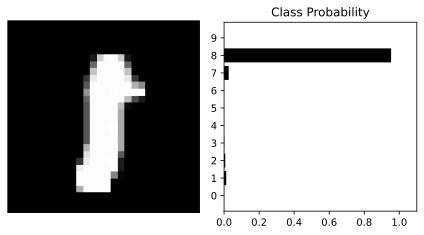

In [36]:
%matplotlib inline
def make_prediction(data):
    images, labels = next(iter(data))

    img = images[42].view(1, 784)

    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    view_classify(img.view(1, 28, 28), ps)
make_prediction(test_loader)

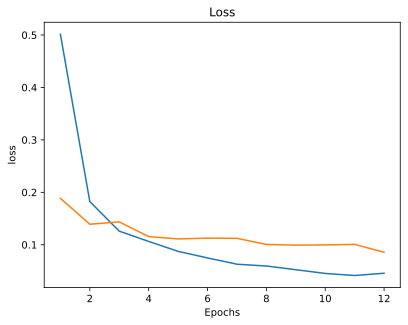

In [ ]:
ep_array = np.arange(epochs) + 1
plt.plot(ep_array, train_losses, label = 'Train losses')
plt.plot(ep_array, test_losses, label = 'Test losses')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.show()